INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore
W0000 00:00:1736509331.226770    4729 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "bilinear" } } inputs { dtype: DT_FLOAT shape { dim { size: -2484 } dim { size: -2485 } dim { size: -2486 } dim { size: 1088 } } } inputs { dtype: DT_FLOAT shape { dim { size: -105 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -105 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } value { dtype: DT_INT32 tensor_shape { dim { size: 2 } } int_val: 17 } } device { type: "CPU" vendor: "GenuineIntel" model: "106" frequency: 2900 num_cores: 64 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cac

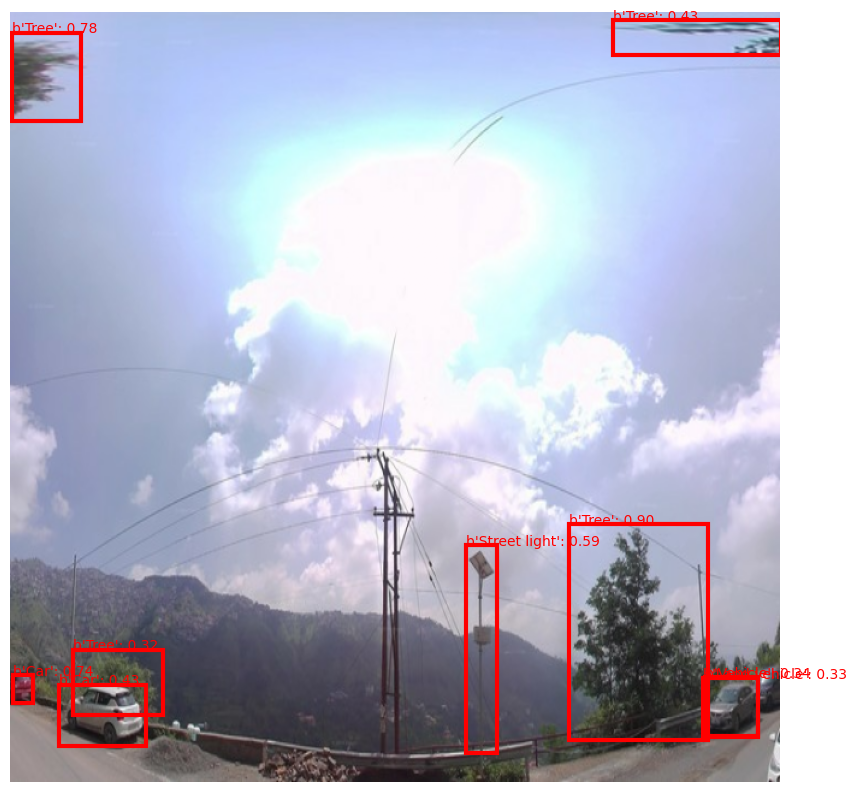

In [4]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
import os

# Define the resize_and_save function
def resize_and_save(image_path, final_path, width, height):
    pil_image = Image.open(image_path)
    pil_image = ImageOps.fit(pil_image, (width, height), Image.LANCZOS)  # Use LANCZOS instead of ANTIALIAS
    pil_image_rgb = pil_image.convert("RGB")
    pil_image_rgb.save(final_path, format="JPEG", quality=90)

# Load the TensorFlow Hub model
module_handle = "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1"
detector = hub.load(module_handle).signatures['default']

# Image processing directory path
image_dir_path = '/home/storage/Backup_E/phd/Object_detection/Data/Cut_pics/Region 16'
resized_street_image_dims_width = 700
resized_street_image_dims_height = 450

# First, process the specific image
specific_image = '31.09053691_77.19548735___5360.jpg'
image_path = os.path.join(image_dir_path, specific_image)
resize_and_save(image_path, image_path, resized_street_image_dims_width, resized_street_image_dims_height)

# Load and preprocess the resized image
image = tf.io.read_file(image_path)
image = tf.image.decode_image(image, channels=3)
image = tf.image.resize(image, (640, 640))
image = tf.expand_dims(image, axis=0)  # Add batch dimension
image = tf.cast(image, tf.float32) / 255.0  # Normalize the image

# Run object detection
output_dict = detector(image)

# Extract relevant outputs
boxes = output_dict['detection_boxes'].numpy()
scores = output_dict['detection_scores'].numpy()
classes = output_dict['detection_class_entities'].numpy()

# Visualize results
threshold = 0.3
detected_indices = np.where(scores >= threshold)

plt.figure(figsize=(10, 10))
plt.imshow(tf.squeeze(image).numpy())
ax = plt.gca()

for i in detected_indices[0]:
    box = boxes[i]
    ymin, xmin, ymax, xmax = box
    ax.add_patch(plt.Rectangle((xmin * image.shape[2], ymin * image.shape[1]),
                               (xmax - xmin) * image.shape[2],
                               (ymax - ymin) * image.shape[1],
                               fill=False, color='red', linewidth=3))
    plt.text(xmin * image.shape[2], ymin * image.shape[1],
             f'{classes[i]}: {scores[i]:.2f}', color='red')

plt.axis('off')
plt.show()

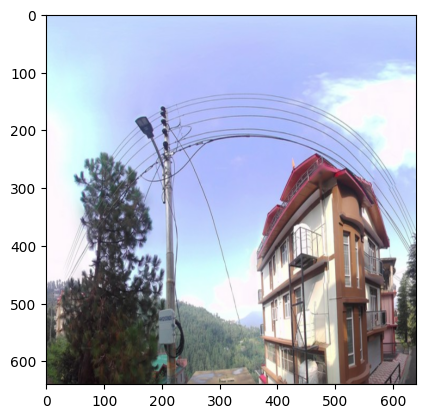

In [5]:
plt.imshow(tf.squeeze(image).numpy())

In [5]:
import tensorflow as tf
with tf.device('/CPU:0'):
    # Your model loading and inference code here
    detector = hub.load(module_handle).signatures['default']
    # ... rest of your code ...

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
import os

def resize_and_save(image_path, final_path, width, height):
    print(f"Resizing and saving image: {image_path}")
    pil_image = Image.open(image_path)
    pil_image = ImageOps.fit(pil_image, (width, height), Image.LANCZOS)
    pil_image_rgb = pil_image.convert("RGB")
    pil_image_rgb.save(final_path, format="JPEG", quality=95)
    print(f"Resized image saved to: {final_path}")

def crop_and_save(original_image, box, save_path, expand_factor=0.1, min_dim=200):
    print(f"Attempting to crop and save image to: {save_path}")
    
    img_height, img_width, _ = original_image.shape

    ymin, xmin, ymax, xmax = box

    # Calculate expansion in both height and width
    box_width = xmax - xmin
    box_height = ymax - ymin
    expand_w = box_width * expand_factor
    expand_h = box_height * expand_factor

    # Expand the bounding box
    xmin_expanded = max(0, xmin - expand_w)
    ymin_expanded = max(0, ymin - expand_h)
    xmax_expanded = min(1, xmax + expand_w)
    ymax_expanded = min(1, ymax + expand_h)

    # Convert normalized coordinates back to image coordinates
    xmin_pixel = int(xmin_expanded * img_width)
    ymin_pixel = int(ymin_expanded * img_height)
    xmax_pixel = int(xmax_expanded * img_width)
    ymax_pixel = int(ymax_expanded * img_height)

    # Crop the image using the expanded bounding box
    cropped_image = original_image[ymin_pixel:ymax_pixel, xmin_pixel:xmax_pixel]
    
    # Calculate the width and height of the cropped image
    cropped_height, cropped_width, _ = cropped_image.shape

    # Check if the cropped image meets the minimum dimension requirement
    if cropped_width < min_dim or cropped_height < min_dim:
        print(f"Skipping image with dimensions {cropped_width}x{cropped_height} (below {min_dim}px).")
        return  # Skip saving this cropped image

    # Convert back to uint8 and scale to 0-255 range
    cropped_image = (cropped_image * 255).astype(np.uint8)

    # Save the cropped image
    try:
        cropped_image_pil = Image.fromarray(cropped_image)
        cropped_image_pil.save(save_path, format="PNG", quality=95)  # Use high quality for saving
        print(f"Successfully saved image to {save_path}")
    except Exception as e:
        print(f"Error saving image: {str(e)}")

def calculate_iou(box1, box2):
    # Calculate intersection over union of two boxes
    y1_1, x1_1, y2_1, x2_1 = box1
    y1_2, x1_2, y2_2, x2_2 = box2

    intersection_y1 = max(y1_1, y1_2)
    intersection_x1 = max(x1_1, x1_2)
    intersection_y2 = min(y2_1, y2_2)
    intersection_x2 = min(x2_1, x2_2)

    intersection_area = max(0, intersection_x2 - intersection_x1) * max(0, intersection_y2 - intersection_y1)
    
    box1_area = (x2_1 - x1_1) * (y2_1 - y1_1)
    box2_area = (x2_2 - x1_2) * (y2_2 - y1_2)
    
    union_area = box1_area + box2_area - intersection_area
    
    iou = intersection_area / union_area if union_area > 0 else 0
    return iou

# Define the classes we're interested in
TARGET_CLASSES = ['House', 'Building', 'Skyscraper', 'Tower']

# Load the TensorFlow Hub model
print("Loading TensorFlow Hub model...")
module_handle = "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1"
detector = hub.load(module_handle).signatures['default']
print("Model loaded successfully.")

# Image processing directory paths
image_dir_path = '/home/storage/Backup_E/phd/Object_detection/Data/Cut_pics/Region 17'
image_dir_path_2 = '/home/storage/Backup_E/phd/Object_detection/Data/Detected buildings/Region 17'
resized_street_image_dims_width = 700
resized_street_image_dims_height = 450

# Ensure the output directory exists
os.makedirs(image_dir_path_2, exist_ok=True)
print(f"Output directory: {image_dir_path_2}")

# Iterate over all images in the folder
image_files = [f for f in os.listdir(image_dir_path) if f.endswith(('.jpg', '.jpeg', '.png'))]

for image_file in image_files:
    image_path = os.path.join(image_dir_path, image_file)
    
    # Resize and save the image (optional step, you can uncomment if needed)
    # resize_and_save(image_path, image_path, resized_street_image_dims_width, resized_street_image_dims_height)

    # Load and preprocess the image
    print(f"Loading and preprocessing image: {image_path}")
    image = tf.io.read_file(image_path)
    image = tf.image.decode_image(image, channels=3)
    image = tf.image.resize(image, (640, 640))
    image = tf.expand_dims(image, axis=0)  # Add batch dimension
    image = tf.cast(image, tf.float32) / 255.0  # Normalize the image
    print(f"Preprocessed image shape: {image.shape}")

    # Run object detection
    print("Running object detection...")
    output_dict = detector(image)

    # Extract relevant outputs
    boxes = output_dict['detection_boxes'].numpy()
    scores = output_dict['detection_scores'].numpy()
    classes = output_dict['detection_class_entities'].numpy()

    # Set a threshold and select detected boxes
    threshold = 0.3
    detected_indices = np.where(scores >= threshold)[0]

    print(f"Number of detected objects: {len(detected_indices)}")

    # Get the original image (before batch dimension was added)
    original_image = tf.squeeze(image).numpy()

    # List to store final detections
    final_detections = []

    # IoU threshold
    iou_threshold = 0.5

    # Process detections
    for i in detected_indices:
        class_name = classes[i].decode('utf-8').capitalize()
        
        if class_name in TARGET_CLASSES:
            current_box = boxes[i]
            current_score = scores[i]
            
            # Check if this detection overlaps significantly with any existing detection
            is_duplicate = False
            for existing_detection in final_detections:
                if calculate_iou(current_box, existing_detection['box']) > iou_threshold:
                    # If it's a duplicate, keep the one with higher score
                    if current_score > existing_detection['score']:
                        final_detections.remove(existing_detection)
                        final_detections.append({
                            'class': class_name,
                            'box': current_box,
                            'score': current_score,
                            'index': i
                        })
                    is_duplicate = True
                    break
            
            # If it's not a duplicate, add it to final detections
            if not is_duplicate:
                final_detections.append({
                    'class': class_name,
                    'box': current_box,
                    'score': current_score,
                    'index': i
                })

    # Crop and save final detections
    for detection in final_detections:
        class_name = detection['class']
        box = detection['box']
        score = detection['score']
        index = detection['index']
        
        # Define a save path for the cropped image
        cropped_image_save_path = os.path.join(image_dir_path_2, f'cropped_{class_name}_{index}.jpg')
        
        print(f"\nProcessing detection for {class_name}")
        print(f"Class: {class_name}, Score: {score:.2f}")
        
        # Crop and save the bounding box image with expansion, only if the dimensions are >= 200
        crop_and_save(original_image, box, cropped_image_save_path, expand_factor=0.1, min_dim=200)

print("Processing complete for all images.")

In [ ]:
from PIL import Image
import os

folder_path = '/home/storage/Backup_E/phd/Object_detection/Data/Cut_pics/Region 17'

# Loop through the images in the folder
for filename in os.listdir(folder_path):
    if filename.endswith(('.png', '.jpg', '.jpeg', '.bmp')):
        image_path = os.path.join(folder_path, filename)
        try:
            with Image.open(image_path) as img:
                img.load()  # Force loading of the image
            # print(f"Successfully loaded: {filename}")
        except (IOError, SyntaxError, ValueError) as e:
            print(f"Corrupted image: {filename} - Error: {e}")
            # Optionally remove the corrupted image
            # os.remove(image_path)


In [1]:
import os
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
from PIL import Image, ImageOps
import matplotlib.pyplot as plt

# Function to crop and save the image
def crop_and_save(original_image, box, save_path, expand_factor=0.1, min_dim=200):
    img_height, img_width, _ = original_image.shape
    ymin, xmin, ymax, xmax = box

    # Calculate expansion in both height and width
    box_width = xmax - xmin
    box_height = ymax - ymin
    expand_w = box_width * expand_factor
    expand_h = box_height * expand_factor

    # Expand the bounding box
    xmin_expanded = max(0, xmin - expand_w)
    ymin_expanded = max(0, ymin - expand_h)
    xmax_expanded = min(1, xmax + expand_w)
    ymax_expanded = min(1, ymax + expand_h)

    # Convert normalized coordinates back to image coordinates
    xmin_pixel = int(xmin_expanded * img_width)
    ymin_pixel = int(ymin_expanded * img_height)
    xmax_pixel = int(xmax_expanded * img_width)
    ymax_pixel = int(ymax_expanded * img_height)

    # Crop the image using the expanded bounding box
    cropped_image = original_image[ymin_pixel:ymax_pixel, xmin_pixel:xmax_pixel]
    
    cropped_height, cropped_width, _ = cropped_image.shape

    # Check if the cropped image meets the minimum dimension requirement
    if cropped_width < min_dim or cropped_height < min_dim:
        return

    # Convert back to uint8 and scale to 0-255 range
    cropped_image = (cropped_image * 255).astype(np.uint8)

    # Save the cropped image
    try:
        cropped_image_pil = Image.fromarray(cropped_image)
        cropped_image_pil.save(save_path, format="JPEG", quality=180)
    except Exception as e:
        print(f"Error saving image: {str(e)}")

# Function to calculate intersection over union (IoU)
def calculate_iou(box1, box2):
    y1_1, x1_1, y2_1, x2_1 = box1
    y1_2, x1_2, y2_2, x2_2 = box2

    intersection_y1 = max(y1_1, y1_2)
    intersection_x1 = max(x1_1, x1_2)
    intersection_y2 = min(y2_1, y2_2)
    intersection_x2 = min(x2_1, x2_2)

    intersection_area = max(0, intersection_x2 - intersection_x1) * max(0, intersection_y2 - intersection_y1)
    
    box1_area = (x2_1 - x1_1) * (y2_1 - y1_1)
    box2_area = (x2_2 - x1_2) * (y2_2 - y1_2)
    
    union_area = box1_area + box2_area - intersection_area
    
    iou = intersection_area / union_area if union_area > 0 else 0
    return iou

# Define the target classes
TARGET_CLASSES = ['House', 'Building', 'Skyscraper', 'Tower']

# Load the TensorFlow Hub model
module_handle = "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1"
detector = hub.load(module_handle).signatures['default']

# Define the directories for input and output images
image_dir_path = '/home/storage/Backup_E/phd/Object_detection/Data/Cut_pics/Region 20'
image_dir_path_2 = '/home/storage/Backup_E/phd/Object_detection/Data/Detected buildings/Region 20'
os.makedirs(image_dir_path_2, exist_ok=True)

# Get the list of image files in the input directory
image_files = [f for f in os.listdir(image_dir_path) if f.endswith(('.jpg', '.jpeg', '.png'))]

# Process each image
for image_file in image_files:
    image_path = os.path.join(image_dir_path, image_file)

    # Load and preprocess the image
    print(f"Loading and preprocessing image: {image_path}")
    image = tf.io.read_file(image_path)
    image = tf.image.decode_image(image, channels=3)
    image = tf.image.resize(image, (3600, 3600))
    image = tf.expand_dims(image, axis=0)  # Add batch dimension
    image = tf.cast(image, tf.float32) / 255.0  # Normalize the image

    # Run object detection
    output_dict = detector(image)

    # Extract relevant outputs
    boxes = output_dict['detection_boxes'].numpy()
    scores = output_dict['detection_scores'].numpy()
    classes = output_dict['detection_class_entities'].numpy()

    # Set a threshold and select detected boxes
    threshold = 0.3
    detected_indices = np.where(scores >= threshold)[0]

    original_image = tf.squeeze(image).numpy()

    final_detections = []
    iou_threshold = 0.5
    original_image_name = os.path.splitext(image_file)[0]

    # Process detections
    for i, detection_index in enumerate(detected_indices):
        class_name = classes[detection_index].decode('utf-8').capitalize()
        
        if class_name in TARGET_CLASSES:
            current_box = boxes[detection_index]
            current_score = scores[detection_index]
            
            is_duplicate = False
            for existing_detection in final_detections:
                if calculate_iou(current_box, existing_detection['box']) > iou_threshold:
                    if current_score > existing_detection['score']:
                        final_detections.remove(existing_detection)
                        final_detections.append({
                            'class': class_name,
                            'box': current_box,
                            'score': current_score,
                            'index': i
                        })
                    is_duplicate = True
                    break
            
            if not is_duplicate:
                final_detections.append({
                    'class': class_name,
                    'box': current_box,
                    'score': current_score,
                    'index': i
                })

    # Save final cropped detections
    for detection_index, detection in enumerate(final_detections):
        class_name = detection['class']
        box = detection['box']
        score = detection['score']

        cropped_image_save_path = os.path.join(image_dir_path_2, f'{original_image_name}-{detection_index+1}.jpg')

        # Crop and save the bounding box image
        crop_and_save(original_image, box, cropped_image_save_path, expand_factor=0.1, min_dim=200)

print("Processing complete for all images.")

2024-10-20 20:01:52.099145: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-20 20:01:52.116642: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-20 20:01:52.135934: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-20 20:01:52.141510: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-20 20:01:52.159177: I tensorflow/core/platform/cpu_feature_guar

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore
2024-10-20 20:02:20.570878: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Loading and preprocessing image: /home/storage/Backup_E/phd/Object_detection/Data/Cut_pics/Region 20/360_113.jpg__427.jpg


W0000 00:00:1729434866.327207   22676 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "bilinear" } } inputs { dtype: DT_FLOAT shape { dim { size: -2484 } dim { size: -2485 } dim { size: -2486 } dim { size: 1088 } } } inputs { dtype: DT_FLOAT shape { dim { size: -105 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -105 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } value { dtype: DT_INT32 tensor_shape { dim { size: 2 } } int_val: 17 } } device { type: "CPU" vendor: "GenuineIntel" model: "106" frequency: 2900 num_cores: 64 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 25165824 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { dim { size: 

Loading and preprocessing image: /home/storage/Backup_E/phd/Object_detection/Data/Cut_pics/Region 20/360_298.jpg__721.jpg
Loading and preprocessing image: /home/storage/Backup_E/phd/Object_detection/Data/Cut_pics/Region 20/360_279.jpg__360.jpg
Loading and preprocessing image: /home/storage/Backup_E/phd/Object_detection/Data/Cut_pics/Region 20/360_361.jpg__182.jpg
Loading and preprocessing image: /home/storage/Backup_E/phd/Object_detection/Data/Cut_pics/Region 20/360_380.jpg__783.jpg
Loading and preprocessing image: /home/storage/Backup_E/phd/Object_detection/Data/Cut_pics/Region 20/360_281.jpg__526.jpg
Loading and preprocessing image: /home/storage/Backup_E/phd/Object_detection/Data/Cut_pics/Region 20/360_275.jpg__416.jpg
Loading and preprocessing image: /home/storage/Backup_E/phd/Object_detection/Data/Cut_pics/Region 20/360_243.jpg__735.jpg
Loading and preprocessing image: /home/storage/Backup_E/phd/Object_detection/Data/Cut_pics/Region 20/360_176.jpg__744.jpg
Loading and preprocessin